# House Prices: Advanced Regression Techniques
Joanna Broniarek
https://www.kaggle.com/c/house-prices-advanced-regression-techniques
---------------

Before starting project I decided to read some articles:
1. https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

    + Select Data: Integrate data, de-normalize it into a dataset, collect it together.
    + Preprocess Data: Format it, clean it, sample it so you can work with it.
    + Transform Data: Feature Engineer happens here.
    + Model Data: Create models, evaluate them and tune them.
    + 
2. https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

2. 6 top factors  that influence a home’s value: https://www.inman.com/2017/08/07/6-factors-that-influence-a-homes-value/
3. https://www.rochesterrealestateblog.com/what-factors-influence-the-sale-price-of-a-home/
_______________

Data tidying
1. removed rows with > 90% NA
2. removed outliers (var X > mean(X) + 3*sd(X)) ----> Z-score method
3. normalization…

Feature engineering
1. created feature MyFoo defined as XYZ that captures aspect ABC
…

Modelization
1. linear regression
2. clustering on features A, B, C

Training
1. average of 10-folds cross validation
2. LASSO model selection

### Reguly:

1- the submission consists of (1) a submission to the Kaggle competition, and (2) a submission to the Project gradeable on our server (http://18.184.187.134)

2- for Kaggle, you must submit as a Kaggle Team, and the team name (competition menu -> Team Name) must contain the ID of a team member

3- for our server, you must submit a ZIP file not exceeding 1MB that contains (A) a concise summary, and (B) the main Python or R scripts/notebook and other optional scripts (e.g. your own python module)

4- the summary must be a PDF file, must not exceed 1 page, and must follow the structure in the attached sample file (in particular it must give the Kaggle team name

5- there is no restriction on packages and/or on techniques you can use

6- exam booking dates apply; e.g. to get your project evaluated for the exam call of Jan 18, submit no later than Jan 16. Late submissions will not be considered

7- grading is performed in two stages. First, if the summary and/or scripts are not well organised and understandable, then the project is deemed insufficient. Otherwise, the grade is primarily on the Kaggle score achieved. 

As a rule of thumb, a **score <= .112 means 30/30**, a score = .122 means 24/30, a score >= .132 means <= 18/30. Bonuses or penalties can be given on a per-case basis

8- you can resubmit to a later exam call only if you improve significantly your Kaggle score (by at least -1%)

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [181]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, OneHotEncoder
# from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
import sys
# import re
import sklearn_pandas
import numpy as np

#Remember to change the path!!!

# path = r'C:\Users\Asia\Desktop\FUW17-18\kaggle-titanic-master\category_encoders-1.2.6'
# sys.path.insert(0, path)
# from category_encoders import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split

import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression

In [182]:
sklearn.__version__
# seaborn.__version__

'0.20.1'

### Reading CSV file as Dataframe:

In [183]:
data_df = pd.read_csv("C:/Users/Asia/fdf_kaggle_project/train.csv")
test_df = pd.read_csv("C:/Users/Asia/fdf_kaggle_project/test.csv")

In [184]:
all_data = pd.concat((data_df.loc[:,:], test_df.loc[:, :]))
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


### EDA - Exploratory Data Analysis

I noticed that the dataset consists of 38 numerical columns of 81 all. 
Morover, some columns contain missing data, i.e."LotFrontage", "MasVnrArea".

**The label which I would like to predict is 'SalePrice'. Let's look closer to this column.**

In [185]:
# Basic information:
data_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

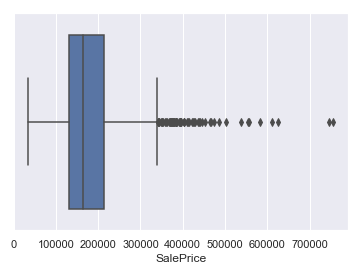

In [186]:
sns.boxplot(data_df['SalePrice'])

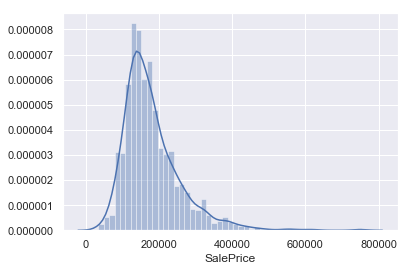

In [187]:
# The Density Plot of SalePrice
sns.distplot(data_df['SalePrice'])

**It is right-skewed distribution with the pick around 160k and quite long tail with maximum about 800k. **

In [188]:
#Skeweness
data_df['SalePrice'].skew()

1.8828757597682129

## Data tidying // PREPROCESSING

#### Removing columns with Nan values

Checking the fraction of Nan values in --> train set dataframe. The columns with value > 0.9 will be removed from the dataframe.

In [189]:
# Getting names of columns to drop out (with more than 90 % of Nan values)
col_nan = data_df.isna().sum() / data_df.shape[0]
drop_out_columns = data_df.columns[[inx for inx, i in enumerate(col_nan >= 0.9) if i==True]]

In [190]:
print("Columns with more than 90 % of NaN values : {}".format(list(drop_out_columns)))

Columns with more than 90 % of NaN values : ['Alley', 'PoolQC', 'MiscFeature']


In [191]:
# Dropping columns for both tarin and test dataset
data_df = data_df.drop(drop_out_columns, axis=1)
test_df = test_df.drop(drop_out_columns, axis=1)

In [192]:
# TODO: >>> Drop "Id" column:

# all_data_df = all_data_df.drop('Id', axis=1) #### ???????????????????????

**Removing rows where SalePrice is NAN**

In [193]:
data_df = data_df.dropna(subset=['SalePrice'])

 **Removing outliers**

I will use **Z-score method** to detect the outliers. Z-scores are expressed in terms of standard deviations from their means. As a result, these z-scores have a distribution with a mean of 0 and a standard deviation of 1.  

I will set a **threshold = 3** to identify outliers.
$$ z = \frac{x - \mu}{\sigma} $$


In [194]:
def remove_outliers(dataset, threshold, columns=None, removed = False):
    """ 
    Z-score method.
    Function returns a dataframe without rows labeled as 'outliers' according to the given threshold.  
    ---------------
    If columns = None, transform all numerical columns.
    If removed = True, return also dataframe with removed rows.
    """
    if columns==None:
        numerics = ['int64','float64']
        columns = dataset.select_dtypes(include=numerics).columns
    
    tmp = dataset.copy()
    z = np.abs(stats.zscore(tmp[columns]))
    outliers = [row.any() for row in (z > threshold)]  
    outliers_idxs = tmp.index[outliers].tolist()
    print("Number of removed rows = {}".format(len(outliers_idxs)))
    if removed: return dataset.drop(outliers_idxs), tmp.loc[outliers]
    else: return dataset.drop(outliers_idxs)

In [195]:
# TODO: choose appropriate values! ????????????????????????????????????????
clear_data, removed_data = remove_outliers(data_df, threshold = 3, removed=True, 
                             columns=['OverallQual', 'TotalBsmtSF', 'GrLivArea', 
                                      'GarageCars', 'FullBath', 'SalePrice'])

Number of removed rows = 36


**Log transformation of skewed features**

In [196]:
# Logarithm transformation of the label column:
# clear_data["SalePrice"] = np.log1p(clear_data["SalePrice"])

In [197]:
# collecting the numeric features
num_features = clear_data.select_dtypes(include=['int64','float64']).columns
num_features = [feat for feat in num_features if feat != 'SalePrice'] #without considering SalePrice

# columns with skew more than 0.7
skewed_features = clear_data[num_features].apply(lambda x: x.dropna().skew())
skewed_features = skewed_features[skewed_features > 0.7].index

# applying log-transformation both for train (clear_data) and test set
clear_data[skewed_features] = np.log1p(clear_data[skewed_features])
test_df[skewed_features] = np.log1p(test_df[skewed_features])

**Replacing missing values in numerical columns**

The SimpleImputer is the Imputation transformer for completing missing values, where "strategy" is the imputation strategy. I am replacing missing values using the mean method.

In [198]:
# Generating numerical features as input to DataFrameMapper.  
numeric_features = sklearn_pandas.gen_features(columns=[num_features], 
                                               classes=[{'class': SimpleImputer, 
                                                         'strategy': 'mean', 
                                                         'missing_values' : np.nan}])
mapper = sklearn_pandas.DataFrameMapper(numeric_features)

# Fitting
imputed_mean = mapper.fit(clear_data.copy())

# Transformation both train and test set
imputed_features = imputed_mean.transform(clear_data)
imp_test = imputed_mean.transform(test_df)

# Putting into dataframe
imputed_df = pd.DataFrame(imputed_features, index=clear_data.index, columns=num_features)
imputed_test_df = pd.DataFrame(imp_test, index=test_df.index, columns=num_features)

**Label Encoding - Categorical to numeral**

In [199]:
# Select category features
cat_feats = clear_data.select_dtypes(include=['object']).columns

According to description about data on Kaggle, I created a list of conversion values, specific for each column.

In [200]:
none_conversion = [("MasVnrType","None"),
                  ("BsmtQual","NA"), 
                  ("Electrical", "None"),
                  ("BsmtCond","NA"),
                  ("BsmtExposure","No"),
                  ("BsmtFinType1","No"),
                  ("BsmtFinType2","No"),
                  ("CentralAir","N"),
                  ("Condition1","Norm"),
                  ("Condition2","Norm"),
                  ("ExterCond","TA"),
                  ("ExterQual","TA"),
                  ("Fence","No"), 
                  ("FireplaceQu","NA"),
                  ("Functional","Typ"),
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","NA"), 
                  ("GarageCond","NA"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"), 
                  ("Functional","Typ"), 
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","No"), 
                  ("GarageCond","No"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"),
                  ("Utilities","AllPub"),
                  ("MSZoning", "None"),
                  ("Exterior1st", "None"),
                  ("Exterior2nd", "None"),
                  ("SaleType", "None")]

In [201]:
def none_transform(df, conversion_list):
    ''' Function that converts missing categorical values 
    into specific strings according to "conversion_list" 
    
    Returns the dataframe after transormation.
    '''
    
    for col, new_str in conversion_list:
        df.loc[:, col] = df.loc[:, col].fillna(new_str)
    return df

In [202]:
# Applying the "none_transform" function for both train and test set
clear_data = none_transform(clear_data, none_conversion)
test_df = none_transform(test_df, none_conversion)

As **Neighbourhood** according to a lot of sources have a big influence on house prices, I would like to look closer to this feature.


In [203]:
# Unique values:
clear_data.Neighborhood.unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'ClearCr', 'NPkVill', 'StoneBr', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

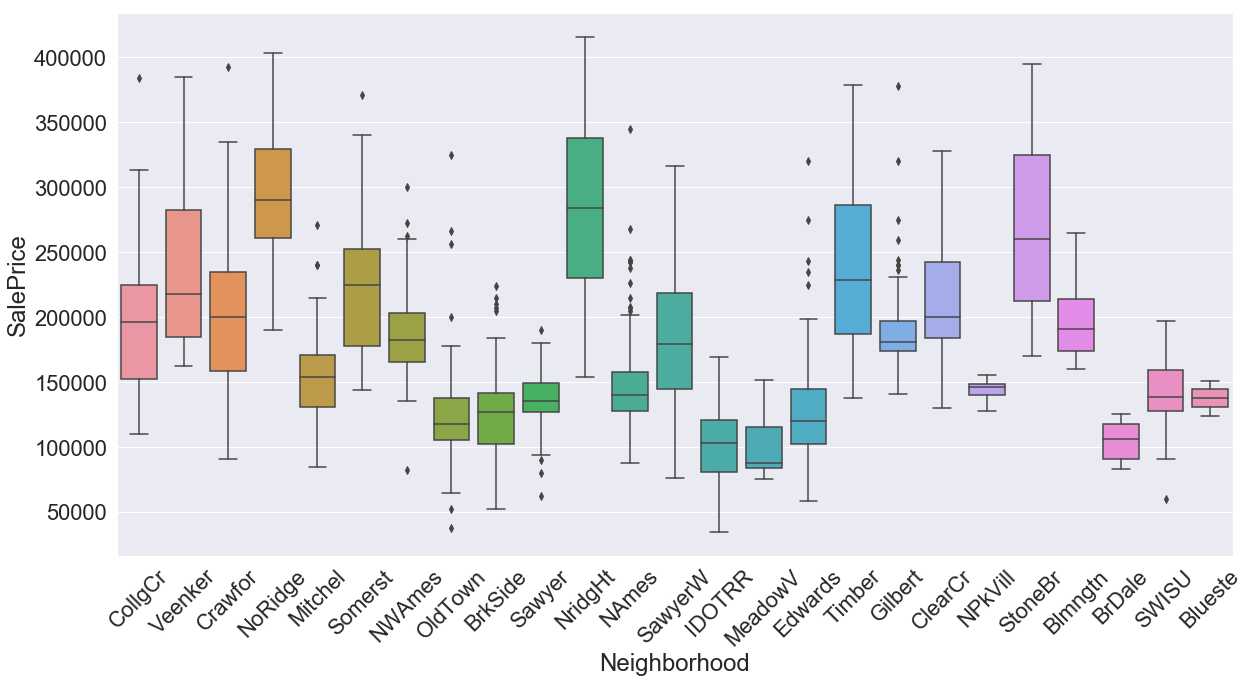

In [204]:
# Boxplot Neighborhood vs. SalePrice
sns.set(font_scale=2)
plt.figure(figsize=(20,10))
sns.boxplot(y="SalePrice", x = "Neighborhood", data = clear_data)
plt.xticks(rotation=45)

Some of the neighborhoods seems to be more expensive than the others, so I decided to create a specific Mapper for **Neighborhood** column. 

Those with names: 'StoneBr', 'NridgHt', 'NoRidge' I will convert as 2, with names:'MeadowV', 'IDOTRR', 'BrDale' as 1 and the rest as 0. 

In [205]:
class NeighborhoodTransformer(BaseEstimator, TransformerMixin):
    neighborhoodsmap = {'StoneBr' : 2, 'NridgHt' : 2, 'NoRidge': 2, 
                        'MeadowV' : 0, 'IDOTRR' : 0, 'BrDale' : 0 ,
                        'CollgCr': 1, 'Veenker' : 1, 'Crawfor' : 1,
                        'Mitchel' : 1, 'Somerst' : 1, 'NWAmes' : 1,
                        'OldTown' : 1, 'BrkSide' : 1, 'Sawyer' : 1, 
                        'NAmes' : 1, 'SawyerW' : 1, 'Edwards' : 1,
                        'Timber' : 1, 'Gilbert' : 1, 'ClearCr' : 1,
                        'NPkVill' : 1, 'Blmngtn' : 1, 'SWISU' : 1,
                        'Blueste': 1}

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.neighborhoodsmap[t]
        return np.array([get_label(n) for [n] in X])

As some categorical features (i.e. **KitchenQual**, **GarageQual**) can be transformed into the numerical values with some order, I also implemented a new encoder for them. 

In [206]:
class OrderedLabelTransformer(BaseEstimator, TransformerMixin):
    
    orderDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
    
#     orderDict = {"ExterQual":FirstDict, "ExterCond" : FirstDict, 
#                  "HeatingQC" : FirstDict, "KitchenQual" : FirstDict,
#                  "BsmtQual" : SecondDict, "BsmtCond" : SecondDict, 
#                  "FireplaceQU" : SecondDict, "GarageQual" : SecondDict, 
#                  "GarageCond" : SecondDict, "PoolQC" : ThirdDict}
    @staticmethod
    def get_dict(X):
        FirstDict = {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        SecondDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
        ThirdDict = {"NA" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        for d in [FirstDict, SecondDict, ThirdDict]:
            print(set(X), set(d))
            if set(X) == set(d): 
                return d
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.orderDict[t]
        return np.array([get_label(n) for n in X])

**TRANSFORMATION CATEGORICAL INTO NUMERICS**


In [207]:
# Generating features:
order_feats = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual", "BsmtQual", 
               "BsmtCond", "FireplaceQu", "GarageQual", "GarageCond"]
# categ_feats = [c for c in cat_feats.tolist() if c not in ["Neighborhood"] + order_feats]

order_features = sklearn_pandas.gen_features(order_feats, [OrderedLabelTransformer])
neighb_features = [(['Neighborhood'], [NeighborhoodTransformer()])]
# cat_features = sklearn_pandas.gen_features(categ_feats, [CategoricalEncoder])# [LabelEncoder])

# Pipeline
label_encoder = sklearn_pandas.DataFrameMapper(neighb_features + order_features)

# The list with order of column names
cols = ["Neighborhood"] + order_feats

# Transformation both train and test set
transformed_feats = label_encoder.fit_transform(clear_data)
cat_test = label_encoder.fit_transform(test_df)

# Putting transformed features into dataframe
transformed_df = pd.DataFrame(transformed_feats, index=clear_data.index, columns=cols)
cat_test_df = pd.DataFrame(cat_test, index=test_df.index, columns=cols)

**One-hot encoding**

"Some machine learning techniques require you 
to drop one dimension from the representation so as 
to avoid dependency among the variables. 
Use "drop_first=True" to achieve that."

In [208]:
categ_feats = [c for c in cat_feats.tolist() if c not in ["Neighborhood"] + order_feats]

# One-hot encoding for categorical features both in train and test dataset
dummies_df = pd.get_dummies(clear_data[categ_feats], prefix=categ_feats, drop_first=True, dummy_na=False)
dummies_test_df = pd.get_dummies(test_df[categ_feats], prefix=categ_feats, drop_first=True, dummy_na=False)

# This will encode the test data in the same way as your training data, 
# filling in 0 for dummy features that weren't created by encoding the test data but were created in during the training process.
dummies_test_df = dummies_test_df.reindex(columns = dummies_df.columns, fill_value=0)

Concatenating 'imputed_df' and 'transformed_df' into one dataframe.

In [209]:
train_df = pd.concat([transformed_df, imputed_df, dummies_df],axis=1)
train_df['SalePrice'] = clear_data['SalePrice']

test_df = pd.concat([cat_test_df, imputed_test_df, dummies_test_df],axis=1)

**Creating new features**

These features seem to be useful for house price prediction. As they are not contained in kaggle dataset I decided to create them from other informations.
+ "TotalSqrtFeet" - Total Live Area  
+ "TotalBaths" - Total Area for Bathrooms

In [210]:
# Total Squere Feet for house
train_df["TotalSqrtFeet"] = train_df["GrLivArea"] + train_df["TotalBsmtSF"]
test_df["TotalSqrtFeet"] = test_df["GrLivArea"] + test_df["TotalBsmtSF"]

# Total number of bathrooms
train_df["TotalBaths"] = train_df["BsmtFullBath"] + (train_df["BsmtHalfBath"]  * .5) + train_df["FullBath"] + (train_df["HalfBath"]* .5)
test_df["TotalBaths"] = test_df["BsmtFullBath"] + (test_df["BsmtHalfBath"]  * .5) + test_df["FullBath"] + (test_df["HalfBath"]* .5)

---------------------------------

# Feature selection considering selected aspects

Let's look at features that are the most correlated with Sale Price

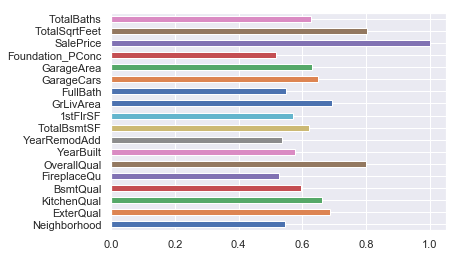

In [211]:
# finding correlatons and printing only those with absolute correlation more than 0.5:
sns.set(font_scale=1)
corr = train_df.corr()
corr[np.abs(corr['SalePrice']) > 0.5]['SalePrice'].plot(kind = "barh")

Let's make **heatmap of correlations** to get the overall look at data.
As the number of features is too big to clearly visualise the heatmap, I decided to show only the correlations bigger than 0.5.

In [31]:
# Correlation matrix - wyswietlac czy nie ??

# sns.set(font_scale=1)
# grid_kws = {"height_ratios": (1, .06), "hspace": .2}
# f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(15, 25))
# sns.heatmap(corr[np.abs(corr) > 0.5], vmax=.9, square=False, center=0, ax=ax, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"})

I found some interesting informations:
+ Some feature like : **OverallQuall, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF**, have quite a high correlation with SalePrice data.
+ There is a strong correlaction between: **TotalBsmtSF, 1stFlrSF** and between:**GarageCars, GarageArea,**, what can suggest that enough information we can get only taking for instance **GarageCars** and **TotalBsmtSF** instead of all.
+ The same situation as above is between **TotRmsAbvGrd** and **GrLivArea**. What seems to be rational. 
+ Morover, some columns seems to be useless in terms of the house price prediction (like PavedDrive or RoofStyle ..), so I remove them for further analysis. 

**My Selected Features**

Accordinig to above analysis and some read articles about the house prices I selected a few features that seems to be useful for the house price predition:
+ **Quality** : OverallQual
+ **Size** : GrLivArea (better correlation than TotalSqrtFeet)
+ **Bathrooms** : TotalBaths
+ **Garage** : GarageCars (little better than GarageArea or GarageType)
+ **Kitchen** : KitchenQual
+ **Neighborhood** : Neighborhood (after transformation)
+ **Year** : YearBuilt
+ **Exterior** : ExterQual
+ SaleCondition: Condition of sale

In [236]:
interesting_columns = ['OverallQual', 'TotalSqrtFeet', 'GarageCars', 
                       'TotalBaths', "KitchenQual", "Neighborhood", 
                       "YearBuilt", "ExterQual", "BsmtQual", "FireplaceQu",
                       "SaleCondition_Normal", "MSZoning_FV", "Functional_Typ"]

In [237]:
# SELECTING FEATURES
selected_features_df = train_df[interesting_columns + ["SalePrice"]]
selected_features_df.head()

,OverallQual,TotalSqrtFeet,GarageCars,TotalBaths,KitchenQual,Neighborhood,YearBuilt,ExterQual,BsmtQual,FireplaceQu,SaleCondition_Normal,MSZoning_FV,Functional_Typ,SalePrice
0,7.0,2566.0,2.0,3.346574,4,1,2003.0,4,4,0,1,0,1,208500
1,6.0,2524.0,2.0,2.346574,3,1,1976.0,3,4,3,1,0,1,181500
2,7.0,2706.0,2.0,3.346574,4,1,2001.0,4,4,3,1,0,1,223500
3,7.0,2473.0,3.0,2.000000,4,1,1915.0,3,3,4,0,0,1,140000
4,8.0,3343.0,3.0,3.346574,4,2,2000.0,4,4,3,1,0,1,250000


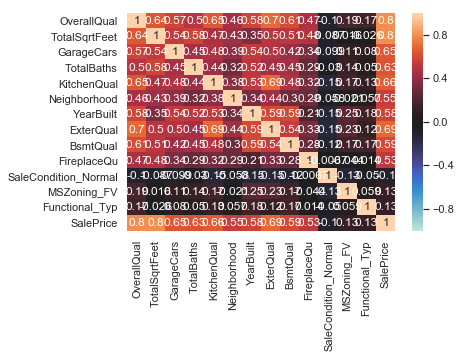

In [238]:
sns.heatmap(selected_features_df.corr(),  annot=True, center=0, vmin=-1, vmax=1)

# Modelization
-----------------------------------

In [244]:
y_train = np.log1p(train_df["SalePrice"])
# X_train = train_df.drop(['SalePrice'], axis=1)
X_train = selected_features_df.drop(['SalePrice'], axis=1)

**Standarize**

In [245]:
notnormalized_frs = list(set(interesting_columns).intersection(set(num_features)))

stdSc = StandardScaler()
X_train.loc[:, notnormalized_frs] = stdSc.fit_transform(X_train.loc[:, notnormalized_frs])
# X_train.loc[:, num_features] = stdSc.fit_transform(X_train.loc[:, num_features])

**Linear Regression**

In [246]:
lr_model = LinearRegression()
scores = cross_val_score(lr_model, X_train, y_train, cv=10)
print("Mean Score = {:.2f}".format(np.mean(scores)))

Mean Score = 0.85


In [247]:
lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)

Text(0.5,1,'Prices vs. Predicted Prices')

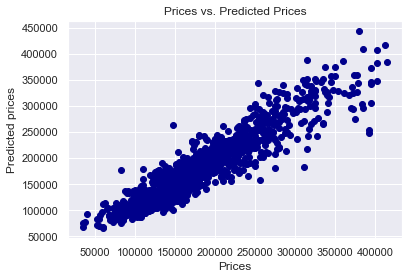

In [248]:
# TODO: Predicted are green
plt.scatter(np.expm1(y_train), np.expm1(y_train_pred), c = "darkblue")
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices")

In [249]:
MSE_train = np.mean((y_train_pred - y_train)**2)
print("Mean Squared Error = {:.3f}".format(MSE_train))

Mean Squared Error = 0.020


Residual plot

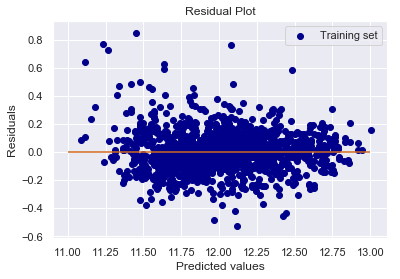

In [250]:
plt.scatter(y_train_pred, y_train_pred - y_train, c = "darkblue", label = "Training set")
plt.hlines(y = 0, xmin = 11., xmax = 13., color = "chocolate")
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper right")

In [251]:
#TODO: Give more conclutions

**Clustering**

K-means ++

In [254]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=12, random_state=0).fit(X_train)

Let's plot predictions and two most correlated features

Text(0.5,1,'TotalSqrtFeet vs OverallQual')

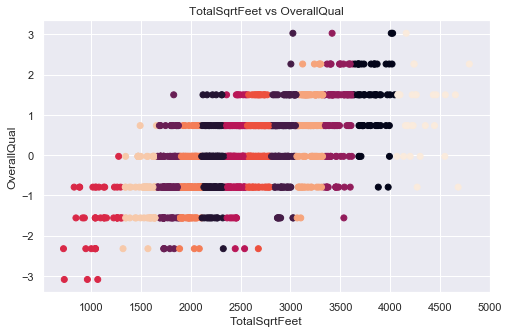

In [255]:
plt.figure(figsize=(8, 5))
plt.scatter(X_train.as_matrix()[:, 1], X_train.as_matrix()[:, 0], c=kmeans.labels_)
plt.xlabel("TotalSqrtFeet")
plt.ylabel("OverallQual")
plt.title("TotalSqrtFeet vs OverallQual")

### KAGGLE SCORE 0.15596 (XGB only selected features) (file: kaggle_predictions3.csv)

# Training
-----------------------------------

In [256]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [257]:
# prawdopodobnie do usuniecia
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

**LASSO model selection**

In [258]:
#TODO: write sth about LASSO

In [260]:
lasso_model = LassoCV(alphas = [0.0001,0.0002, 0.0003, 0.0004, 0.0006, 0.0009, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], cv=10).fit(X_train, y_train)


lasso_model.fit(X_train, y_train)
alpha = lasso_model.alpha_

print("Best alpha : {}", alpha)
print("Lasso RMSE on Training set :", rmse_cv(lasso_model).mean())

Best alpha : {} 0.0001
Lasso RMSE on Training set : 0.14248633505602118


In [261]:
# Predictions
y_train_lasso = lasso_model.predict(X_train)

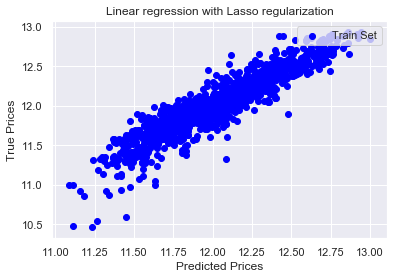

Lasso picked 13 features and eliminated the other 0 features


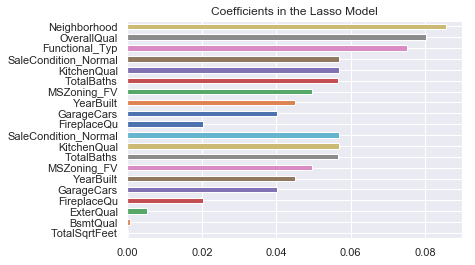

In [262]:
#TODO : zmien troche, to jest kopia

# Plot predictions
plt.scatter(y_train_lasso, y_train, c = "blue", label = "Train Set")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted Prices")
plt.ylabel("True Prices")
plt.legend(loc = "upper right")
# plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso_model.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

**GradientBoostingRegressor**

In [270]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [271]:
gbr = GradientBoostingRegressor(random_state=0)
param_grid = {'n_estimators': [500],
              'max_features': [7, 9, 11, 13],
              'max_depth': [5, 6, 9, 10],
              'learning_rate': [0.05, 0.1, 0.15, 0.2],
              'subsample': [0.8]}

gb_model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=1, cv=10)
gb_model.fit(X_train, y_train)

print('Gradient boosted tree regression...')
print('Best Params:')
print(gb_model.best_params_)
print('Best CV Score:')
print(gb_model.best_score_)

Gradient boosted tree regression...
Best Params:
{'learning_rate': 0.05, 'max_depth': 5, 'max_features': 7, 'n_estimators': 500, 'subsample': 0.8}
Best CV Score:
0.8545512428835058


**XGB Regressor**

In [282]:
xgbreg = xgb.XGBRegressor(seed=0)
param_grid2 = {'n_estimators': [500], 
              'learning_rate': [0.05, 0.1],
              'max_depth': [7, 9],
              'subsample': [0.8],
              'colsample_bytree': [0.75, 0.8, 0.85]}
    
xgb_model = GridSearchCV(estimator=xgbreg, param_grid=param_grid2, n_jobs=1, cv=10)
xgb_model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(xgb_model.best_params_)
print('Best CV Score:')
print(xgb_model.best_score_)

eXtreme Gradient Boosting regression...
Best Params:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
Best CV Score:
0.8581236450034584


In [ ]:
# y_pred = model2.predict(test_X)

## Kaggle Submission

In [274]:
test_X = test_df[interesting_columns]
# test_X = test_df

test_X.loc[:, notnormalized_frs] = stdSc.transform(test_X.loc[:, notnormalized_frs])
# test_X.loc[:, num_features] = stdSc.transform(test_X.loc[:, num_features])

c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [275]:
test_X.shape
# lasso_model.predict(test_X)

(1459, 13)

In [287]:
# y_test_pred = np.expm1(lasso_model.predict(test_X))
# y_test_pred = np.expm1(gb_model.predict(test_X))
# y_test_pred = np.expm1(xgb_model.predict(test_X))

predictions_df = pd.DataFrame(data={"xgb_mode" : np.expm1(xgb_model.predict(test_X)), 
                                    "lasso_model" : np.expm1(lasso_model.predict(test_X)), 
                                    "gb_model" : np.expm1(gb_model.predict(test_X))},
                              index = test_X.index + 1461)
predictions_df["SalePrice"] = predictions_df.mean()

# predictions_df = pd.DataFrame(y_test_pred, 
#                               index = test_X.index + 1461, 
#                               columns=["SalePrice"])
predictions_df.index.name = "Id"
predictions_df.head()

,gb_model,lasso_model,xgb_mode,SalePrice
Id,,,,
1461,65407.524664,3669.903701,56131.945312,NaN
1462,131080.807386,4933.406319,99429.343750,NaN
1463,110558.860511,5299.707614,86082.937500,NaN
1464,129023.434515,5963.773741,93495.445312,NaN
1465,116030.806898,6530.088153,99622.789062,NaN


In [278]:
predictions_df.to_csv("kaggle_predictions10.csv")

In [281]:
np.mean(np.array([1, 2]), np.array([1, 3]), np.array([1, 4]), axis=0)

TypeError: mean() got multiple values for argument 'axis'

## LASSO - all features 0.12377  ("kaggle_predictions4.csv")



## after dummy_feats ("kaggle_predictions7.csv") -bad 
##  on selected feat (ver8) - bad

## GB model - all features   0.14222 ("kaggle_predictions5.csv")

## XGB model - all features   0.75123 ("kaggle_predictions6.csv")

# OLD code

In [210]:
test_df = test_df.drop(drop_out_columns, axis=1)
test_df = test_df.drop('Id', axis=1)

In [211]:
# log transformation
test_df[skewed_features] = np.log1p(test_df[skewed_features])

In [213]:
# Data imputation for numerical columns
test_imputed_features = mapper.fit_transform(test_df.copy()) #only transform ?
test_imputed_df = pd.DataFrame(test_imputed_features, index=test_df.index, columns=num_features)

In [234]:
# TRANSFORMATION CATEGORICAL INTO NUMERICS

# Convertion of None values according to the same principles as train set
test_without_none_df = none_transform(test_df, none_conversion)

In [285]:
# Transformation
test_transformed_feats = label_encoder.fit_transform(test_without_none_df)

# Putting transformed features into dataframe
test_transformed_df = pd.DataFrame(test_transformed_feats, 
                                   index=test_without_none_df.index, 
                                   columns=cols)

In [237]:
test_preprocessed_df = pd.concat([test_transformed_df, test_imputed_df], axis=1)

In [238]:
# Total Squere Feet for house
test_preprocessed_df["TotalSqrtFeet"] = test_preprocessed_df["GrLivArea"] + test_preprocessed_df["TotalBsmtSF"]
# Total number of bathrooms
test_preprocessed_df["TotalBaths"] = test_preprocessed_df["BsmtFullBath"] + (test_preprocessed_df["BsmtHalfBath"]  * .5) + test_preprocessed_df["FullBath"] + (test_preprocessed_df["HalfBath"]* .5)

In [ ]:
interesting_columns = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBaths', "KitchenQual", "Neighborhood", "YearBuilt", "ExterQual"]

In [249]:
# notnormalized_frs = list(set(interesting_columns).intersection(set(num_features)))
# stdSc = StandardScaler()
X_train = selected_features_df.drop(['SalePrice'], axis=1)
y_train = selected_features_df.SalePrice
X_test = test_preprocessed_df[interesting_columns]

X_train.loc[:, notnormalized_frs] = stdSc.fit_transform(train.loc[:, notnormalized_frs])
X_test.loc[:, notnormalized_frs] = stdSc.transform(test.loc[:, notnormalized_frs])

c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [248]:
selected_features_df.head()

,OverallQual,GrLivArea,GarageCars,TotalBaths,KitchenQual,Neighborhood,YearBuilt,ExterQual,SalePrice
0,0.733482,0.612727,0.347523,3.039721,4,1,1.070703,4,208500
1,-0.031143,-0.356099,0.347523,2.346574,3,1,0.168584,3,181500
2,0.733482,0.751419,0.347523,3.039721,4,1,1.003880,4,223500
3,0.733482,0.625756,1.714574,1.693147,4,1,-1.869537,3,140000
4,1.498107,1.413491,1.714574,3.039721,4,2,0.970468,4,250000


In [250]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [284]:
lr.score(X_train, y_train)

0.8055084051542158

In [280]:
y_test_pred = lr.predict(X_test)
predictions_df = pd.DataFrame(y_test_pred, index = X_test.index+1461, columns=["SalePrice"])
predictions_df.index.name = "Id"
predictions_df.head()

,SalePrice
Id,
1461,9.710462e+06
1462,9.737938e+06
1463,9.912069e+06
1464,9.948335e+06
1465,9.986607e+06


In [274]:
# with open('names.csv', 'w') as kaggle_csv:
#     writer = csv.writer(kaggle_csv)
#     writer.writerows(predictions_df)

In [283]:
predictions_df.to_csv("kaggle_predictions.csv")

In [282]:
test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
0,3.044522,RH,4.394449,9.360741,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,4.795791,0.0,MnPrv,0.000000,6,2010,WD,Normal
1,3.044522,RL,4.406719,9.565775,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0.0,0.0,0.000000,0.0,No,9.433564,6,2010,WD,Normal
2,4.110874,RL,4.317488,9.534668,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.000000,0.0,MnPrv,0.000000,3,2010,WD,Normal
3,4.110874,RL,4.369448,9.208238,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.000000,0.0,No,0.000000,6,2010,WD,Normal
4,4.795791,RL,3.784190,8.518392,Pave,IR1,HLS,AllPub,Inside,Gtl,...,0.0,0.0,4.976734,0.0,No,0.000000,1,2010,WD,Normal


### Models - copied from Kaggle tutorial

In [294]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [298]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], cv=10).fit(X_train, y_train)

In [299]:
rmse_cv(model_lasso)

array([29166.94600491, 31121.86359127, 30998.72316333, 29718.28123733,
       35385.04280383, 23213.58530227, 27509.24600688, 26664.27888154,
       30780.772614  , 28313.95357221])

---------------------
# Old code


## Test Set Predictions 

In [87]:
# PREPARING TEST SET

test_df = test_df.drop(drop_out_columns, axis=1)
test_df = test_df.drop('Id', axis=1)

In [91]:
selected_features_test_df = test_df[['OverallQual', 'TotalBsmtSF','GrLivArea','GarageCars','FullBath']]
scaled_features_test = mapper.fit_transform(selected_features_test_df.copy())
scaled_features_test_df = pd.DataFrame(scaled_features_test, index=selected_features_test_df.index, columns=['OverallQual', 'TotalBsmtSF','GrLivArea','GarageCars', 'FullBath'])

In [93]:
scaled_features_test_df.head()

,OverallQual,TotalBsmtSF,GrLivArea,GarageCars,FullBath
0,-0.751101,-0.370808,-1.215588,-0.988013,-1.028720
1,-0.054877,0.639144,-0.323539,-0.988013,-1.028720
2,-0.751101,-0.266876,0.294508,0.301623,0.773083
3,-0.054877,-0.271395,0.243004,0.301623,0.773083
4,1.337571,0.528434,-0.424487,0.301623,0.773083


In [95]:
X_test = scaled_features_test_df[['OverallQual','GrLivArea', 'GarageCars', 'TotalBsmtSF']].as_matrix()

In [96]:
# PREDICTIONS ON TEST SET
reg.predict(X_test)

array([112796.17737749, 165684.4142192 , 159370.40190488, ...,
       153041.05424609, 102177.71977052, 230489.19178417])

--------------------

In [97]:
from sklearn.cluster import KMeans

In [112]:
kmeans = KMeans(init='k-means++', n_clusters=4, random_state=0).fit(X)
kmeans.labels_
# kmeans.predict([[0, 0], [4, 4]])
# array([0, 1], dtype=int32)
# kmeans.cluster_centers_
# array([[1., 2.],
#        [4., 2.]])

array([1, 3, 1, ..., 1, 0, 0])

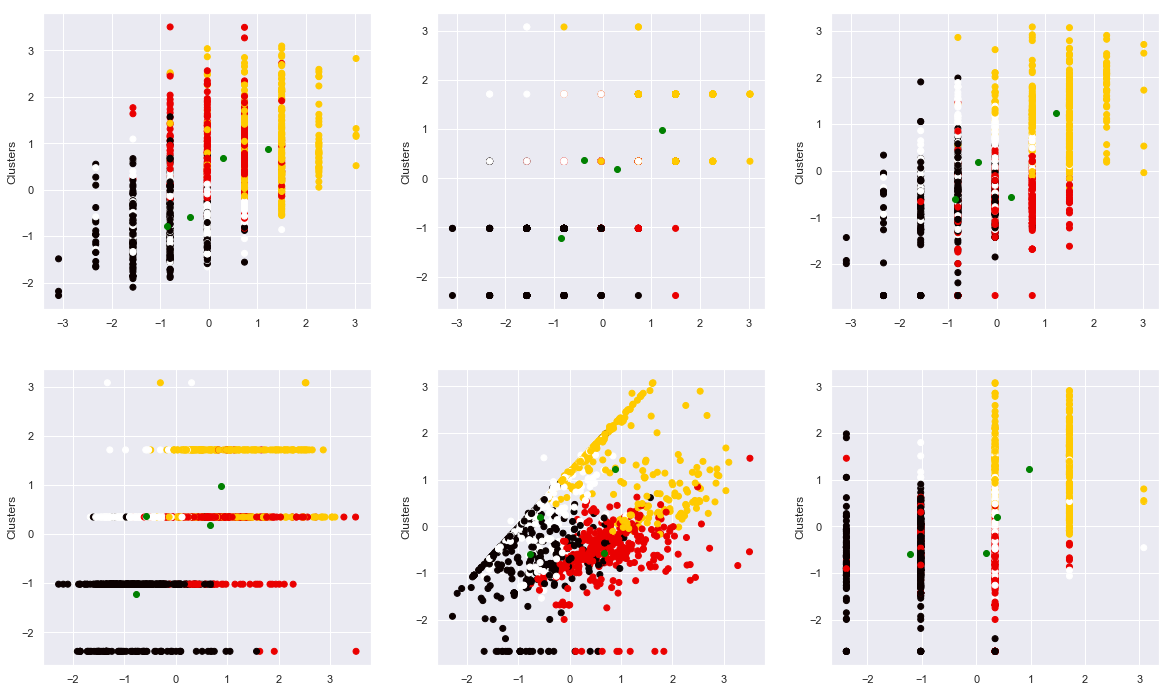

In [116]:
plt.figure(figsize=(20,12))
couples = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
for i in range(1, 7):
    plt.subplot(2, 3, i)
    a, b = couples[i-1]
    plt.scatter(X[:,a],X[:,b], c=kmeans.labels_, cmap='hot')
    plt.scatter(kmeans.cluster_centers_[:,a] ,kmeans.cluster_centers_[:,b], color='green')
    plt.ylabel("Clusters")
#     plt.xlabel(str(x_labels[a]))

### KitchenQual - Label encoding

In [216]:
# kitchen_le = LabelEncoder()
# kitchen_le.fit(list(data_df.loc[:,('KitchenQual')]))
# kitchen_le.classes_
# data_df.loc[:,('KitchenQual')] = kitchen_le.transform(list(data_df.loc[:,('KitchenQual')]))  

In [275]:
# data_df[['KitchenQual']].head()

### Label Encoding

In [290]:
# num_features = sklearn_pandas.gen_features(['LandContour'], StringIndexer)

cat_features = [(['LandContour'], LabelEncoder()), (['KitchenQual'], LabelEncoder()), (['Neighborhood'], LabelEncoder())]
data_pipe = sklearn_pandas.DataFrameMapper(cat_features, df_out=True, input_df=True)
train = data_pipe.fit_transform(data_df, data_df.SalePrice)
data_df['LandContour'] = train['LandContour']
data_df['KitchenQual'] = train['KitchenQual']
data_df['Neighborhood'] = train['Neighborhood']

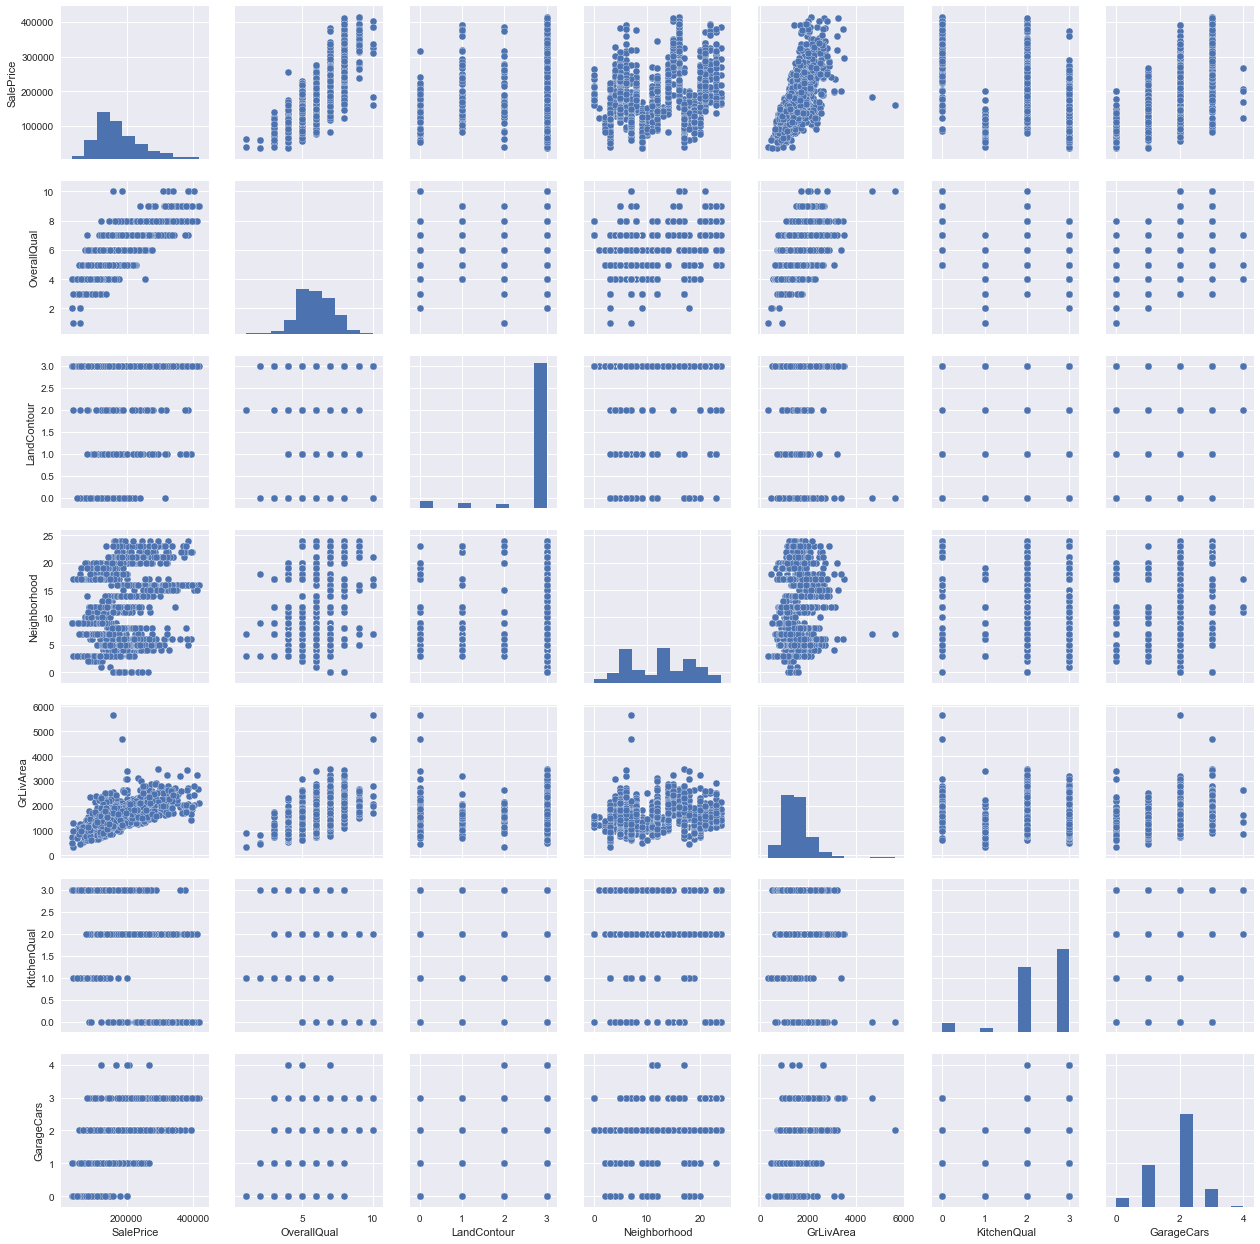

In [295]:
#scatterplot
sns.set()
cols = ["SalePrice", "OverallQual", "LandContour", "Neighborhood", "GrLivArea", "KitchenQual", "GarageCars"]
sns.pairplot(data_df[cols], size = 2.5)
plt.show()

### Feature engineering

+ Imputer - Imputation transformer for completing missing values.
''' missing_values : integer or “NaN”, optional (default=”NaN”)

The placeholder for the missing values. All occurrences of missing_values will be imputed. For missing values encoded as np.nan, use the string value “NaN”.

strategy : string, optional (default=”mean”)

The imputation strategy.

If “mean”, then replace missing values using the mean along the axis.
If “median”, then replace missing values using the median along the axis.
If “most_frequent”, then replace missing using the most frequent value along the axis. '''

+ Standarizing by StandardScaler

In [35]:
num_features = sklearn_pandas.gen_features(columns=[['col1'], ['col2'], ['col3']], classes=[Imputer, StandardScaler])
num_features

c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


[(['col1'],
  [Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
   StandardScaler(copy=True, with_mean=True, with_std=True)]),
 (['col2'],
  [Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
   StandardScaler(copy=True, with_mean=True, with_std=True)]),
 (['col3'],
  [Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
   StandardScaler(copy=True, with_mean=True, with_std=True)])]

In [30]:
# num_features = sklearn_pandas.gen_features([['SibSp'], ['Parch'], ['Fare']], [Imputer])

# cat_features = [
#                 (['Pclass'], CategoricalEncoder()),
#                 (['Embarked'], CategoricalEncoder(categories=['C', 'Q', 'S'])),
#                 (['Sex'], CategoricalEncoder(categories=['female']))
#                ]

# ticket_features = [(['Ticket', 'Sex', 'PassengerId'], TicketStats(), {'alias': 'TicketStats'})]

# cabin_features = [(['Cabin'], CabinFeatures(), {'alias': 'Deck'})]

# title_features = [
#                   (['Name', 'Age'], [CleanTitles(), CategoricalImputer(set(CleanTitles.titlemap.values()), Imputer())], {'alias': 'Age'}),
#                   (['Name'], [CleanTitles(), CategoricalEncoder()], {'alias': 'Title'})
#                  ]

# data_pipe = sklearn_pandas.DataFrameMapper(num_features + cat_features + cabin_features + title_features + ticket_features, df_out=True, input_df=True)
# data_pipe_no_ticket = sklearn_pandas.DataFrameMapper(num_features + cat_features + cabin_features + title_features, df_out=True, input_df=True)

In [ ]:
mapper = DataFrameMapper([(df.columns, StandardScaler())])
scaled_features = mapper.fit_transform(df.copy(), 4)
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

In [235]:
class StringIndexer(BaseEstimator, TransformerMixin):
    def __init__(self, categories=None):
        self.categories = categories
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.categories].apply(lambda s: s.cat.codes.replace({-1: len(s.cat.categories)}))

In [80]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categories=None):
        self.categories = categories
    
    def get_feature_names(self):
        if self.categories is None:
            return [c for c,i in self.onehotencoder_.ordinal_encoder.mapping[0]['mapping']]
        else:
            return self.categories
        
    def fit(self, X, y=None):
        try:
            self.onehotencoder_ = OneHotEncoder(cols = list(X.columns), return_df=False, handle_unknown='ignore')
        except AttributeError:
            self.onehotencoder_ = OneHotEncoder(return_df=False, handle_unknown='ignore')
        self.onehotencoder_.fit(X)
        
    def transform(self, X):
        res = self.onehotencoder_.transform(X)
        if self.categories is not None:
            idxs = [i for c,i in self.onehotencoder_.ordinal_encoder.mapping[0]['mapping'] if c in set(self.categories)]
            return res[:, idxs]
        return res

Reading the **train.csv** file:

----------
+ "Alley" does not contain a lot of information, mostl;y Nan, so we can drop this column
+ Similar situation is with "PoolQC" and "MiscFeature" columns
+ 

## Correlation 

In [ ]:
#### Now, I would like to know more about relationships between features

Let's make heatmap of correlations to get the overall look at data.

= === ------------------------------

#correlation matrix
corrmat = data_df.corr()
f, ax = plt.subplots(figsize=(15, 13))
sns.heatmap(corrmat, vmax=.9, square=True)

= === ---------------

We found some interesting informations:
+ Some feature like : **OverallQuall, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF**, have quite a high correlation with SalePrice data.
+ Strong correlaction between: **TotalBsmtSF, 1stFlrSF** and between:**GarageCars, GarageArea,**, what can suggest that enough information we can get only taking for instance **GarageCars** and **TotalBsmtSF** instead of all.
+ the same situation is between TotRmsAbvGrd and GrLivArea. What seems to be rational. 
+ sth more? maybe negatively correlated?

-= ---------------= -

 Correlations between features and 'SalePrice'
 spearman_df = pd.DataFrame()
 spearman_df['feature'] = data_df.columns
 spearman_df['spearman'] = [data_df[f].corr(data_df['SalePrice'], 'spearman') for f in data_df.columns]
 sorted_spearman_df = spearman_df.sort_values('spearman')
 plt.figure(figsize=(6, 0.25*len(data_df.columns)))
 sns.barplot(data=sorted_spearman_df, y='feature', x='spearman', orient='h')
 
 -=--=================-------
 
 According to correlation and previously general informations from articles I decided to be focused on selected features like:
+ OverallQual
+ LandContour
+ Neighborhood
+ YearBuilt ??? no
+ GrLivArea
+ KitchenQual
+ Electrical ??? no
+ CentralAir ??? no
+ Fireplaces ??? no
+ GarageCars
+ PoolArea ??? no

## Linear Regression

In [320]:
from sklearn.linear_model import LinearRegression

X = new_df.drop(columns=['SalePrice'])
y = new_df[['SalePrice']]
reg = LinearRegression().fit(X, y)
reg.score(X, y)
# reg.coef_
# reg.intercept_ 
# reg.predict(test)

0.7620599642466808

In [319]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [301]:
# data_df.corr()['SalePrice']

In [302]:
# data_df.columns

In [304]:
# data_df = data_df.drop(columns=['Alley', 'PoolQC', 'MiscFeature'])
# data_df.head()

Lets check correlations and cover of the info between columns about **garage**

In [69]:
garage_df = data_df[["GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", "GarageQual", "GarageCond"]]
garage_df.head()

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,Attchd,2003.0,RFn,2,548,TA,TA
1,Attchd,1976.0,RFn,2,460,TA,TA
2,Attchd,2001.0,RFn,2,608,TA,TA
3,Detchd,1998.0,Unf,3,642,TA,TA
4,Attchd,2000.0,RFn,3,836,TA,TA


In [49]:
garage_df.dtypes

GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageCars        int64
GarageArea        int64
GarageQual       object
GarageCond       object
dtype: object

#### Decomposition of Categorical Attributes

In [72]:
# We can convert non-numerical values to some numbers 

from sklearn import preprocessing

le1 = preprocessing.LabelEncoder()
le1.fit(list(garage_df.loc[:,('GarageQual')]))
le1.classes_
garage_df.loc[:,('GarageQual')] = le1.transform(list(garage_df.loc[:,('GarageQual')]))  

le = preprocessing.LabelEncoder()
le.fit(list(garage_df.loc[:,('GarageCond')]))
le.classes_
garage_df.loc[:,('GarageCond')] = le.transform(list(garage_df.loc[:,('GarageCond')]))  

c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [73]:
garage_df.head()

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,Attchd,2003.0,RFn,2,548,4,4
1,Attchd,1976.0,RFn,2,460,4,4
2,Attchd,2001.0,RFn,2,608,4,4
3,Detchd,1998.0,Unf,3,642,4,4
4,Attchd,2000.0,RFn,3,836,4,4


In [74]:
garage_df.corr()

,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond
GarageYrBlt,1.000000,0.588920,0.564567,0.310021,0.256680
GarageCars,0.588920,1.000000,0.882475,-0.117061,-0.162246
GarageArea,0.564567,0.882475,1.000000,-0.096674,-0.139104
GarageQual,0.310021,-0.117061,-0.096674,1.000000,0.597030
GarageCond,0.256680,-0.162246,-0.139104,0.597030,1.000000


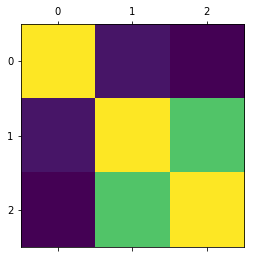

In [47]:
plt.matshow(garage_df.corr())
plt.show()

------------------
At first, I want to analyse the column "MSSubClass"

**MSSubClass:** 
+ Identifies the type of dwelling involved in the sale.

In [22]:
data[["Id", "MSSubClass"]].groupby(by="MSSubClass").count()

,Id
MSSubClass,
20,536
30,69
40,4
45,12
50,144
60,299
70,60
75,16
80,58
